In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

import os

source_path = "/backup/kruu/wake_encounter_simulations"

# Encounter parameters

In [2]:
directories = sorted([d for d in os.listdir(os.path.join(source_path, "encounters")) if d.isdigit()])

dataframes = []

for dir_name in directories:
    file_path = os.path.join(source_path, "encounters", dir_name, "param.parquet")
    
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        df['simulation_index'] = int(dir_name)
        dataframes.append(df)

aggregated_params = pd.concat(dataframes, ignore_index=True)

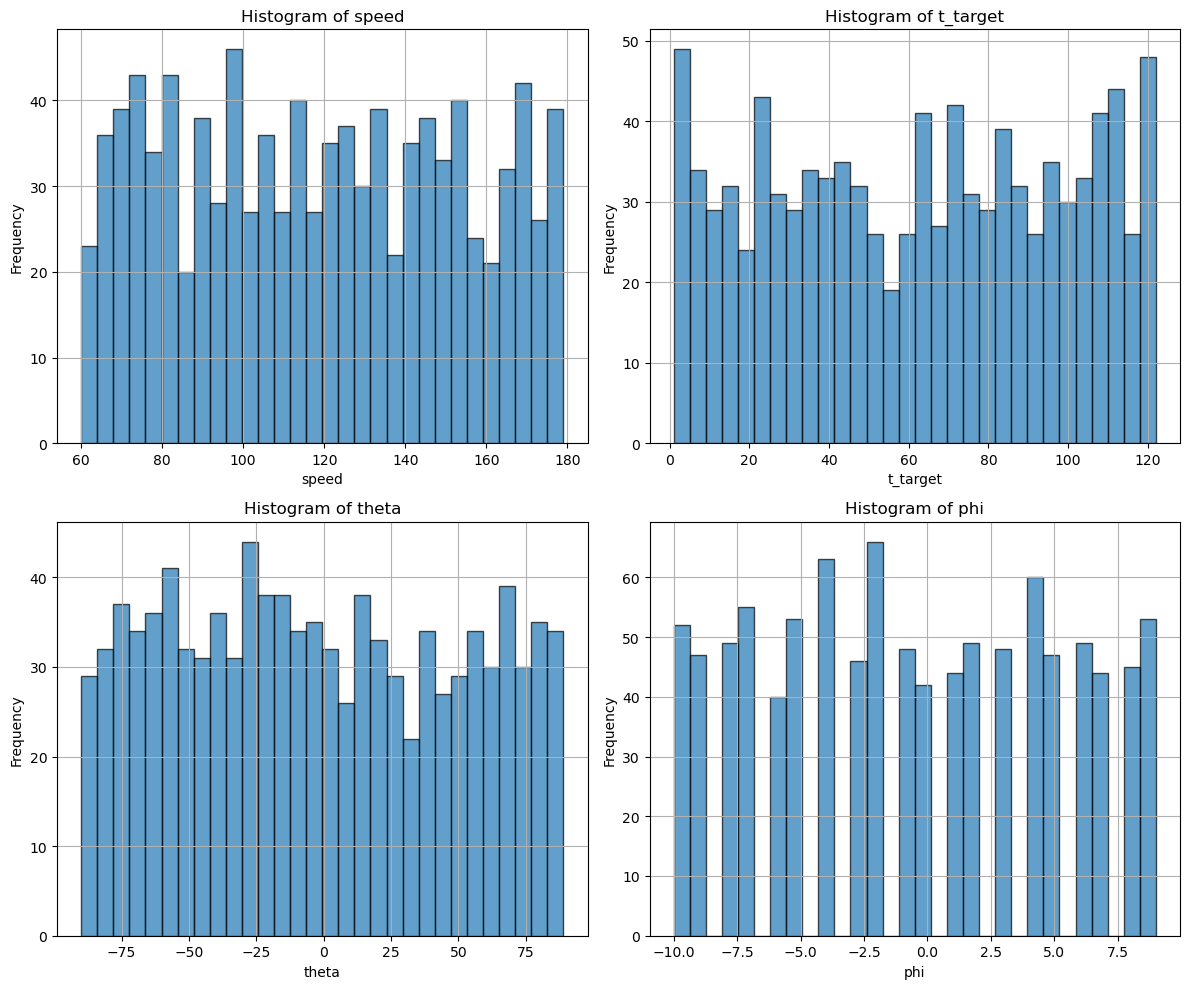

In [4]:
columns_to_plot = ['speed', 't_target', 'theta', 'phi']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

for i, column in enumerate(columns_to_plot):
    if column in aggregated_params.columns:
        axes[i].hist(aggregated_params[column], bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Histogram of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].grid(True)
    else:
        print(f"Column {column} not found in dataframe.")

plt.tight_layout()
plt.show()


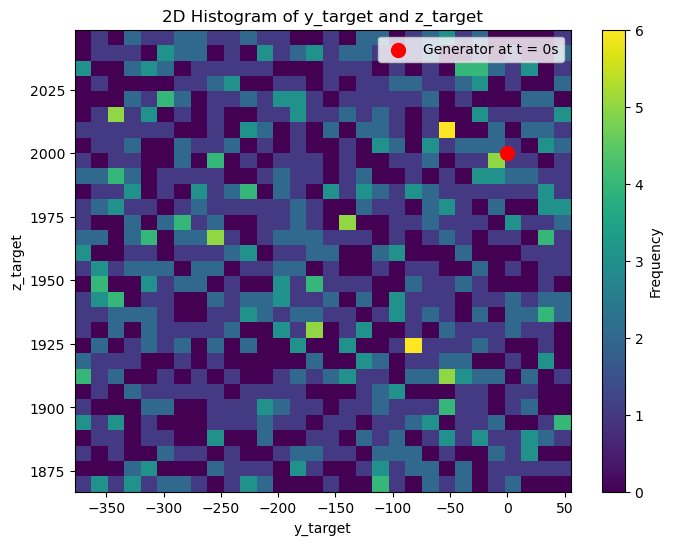

In [5]:
if 'y_target' in aggregated_params.columns and 'z_target' in aggregated_params.columns:
    plt.figure(figsize=(8, 6))
    plt.hist2d(
        aggregated_params['y_target'], 
        aggregated_params['z_target'], 
        bins=30, 
        cmap='viridis'
    )
    plt.colorbar(label='Frequency')
    plt.title('2D Histogram of y_target and z_target')
    plt.xlabel('y_target')
    plt.ylabel('z_target')
    plt.grid(False)
    
    plt.scatter(0, 2000, color='red', label='Generator at t = 0s', s=100)
    plt.legend(loc='upper right')
    plt.show()
else:
    print("Columns 'y_target' and/or 'z_target' not found in dataframe.")


# Wake parameters

In [6]:
sim = aggregated_params["wake_id"].unique()[0]

# Wake parameters
wake_params = pd.read_parquet(os.path.join(source_path, "wakes", str(sim), "param.parquet"))
wake_params

,run_id,alt_aircraft,spread,step,wind_vel,wind_dir,temp,p_ref,tke,speed,mass,wingspan,wind_vertical_vel,alt_sensor,qq,gpa
0,0,2000.0,1000,10,2.0,130.0,288.15,101300.0,10.0,100.0,136000.0,47.3,0.0,10.0,0.05,0.0


# Results

In [7]:
directories = sorted([d for d in os.listdir(os.path.join(source_path, "encounters")) if d.isdigit()])

results = {}

for dir_name in directories:
    file_path = os.path.join(source_path, "encounters", dir_name, "results.parquet")
    
    if os.path.exists(file_path):
        df = pd.read_parquet(file_path)
        results[int(dir_name)] = df

In [10]:
forces = ["C_L", "C_D", "C_Y"] #Lift, Drag, Side
moments = ["C_l", "C_m", "C_n"] #rolling, pitching, yawing

sim_to_plot = np.random.choice(100, size=5, replace=False)
labels = sim_to_plot

# sim_to_plot = aggregated_params.query("80 <= abs(theta)").simulation_index.values
# labels = aggregated_params.query("80 <= abs(theta)").simulation_index.values

# List of dataframes
dataframes = [results[i] for i in sim_to_plot]

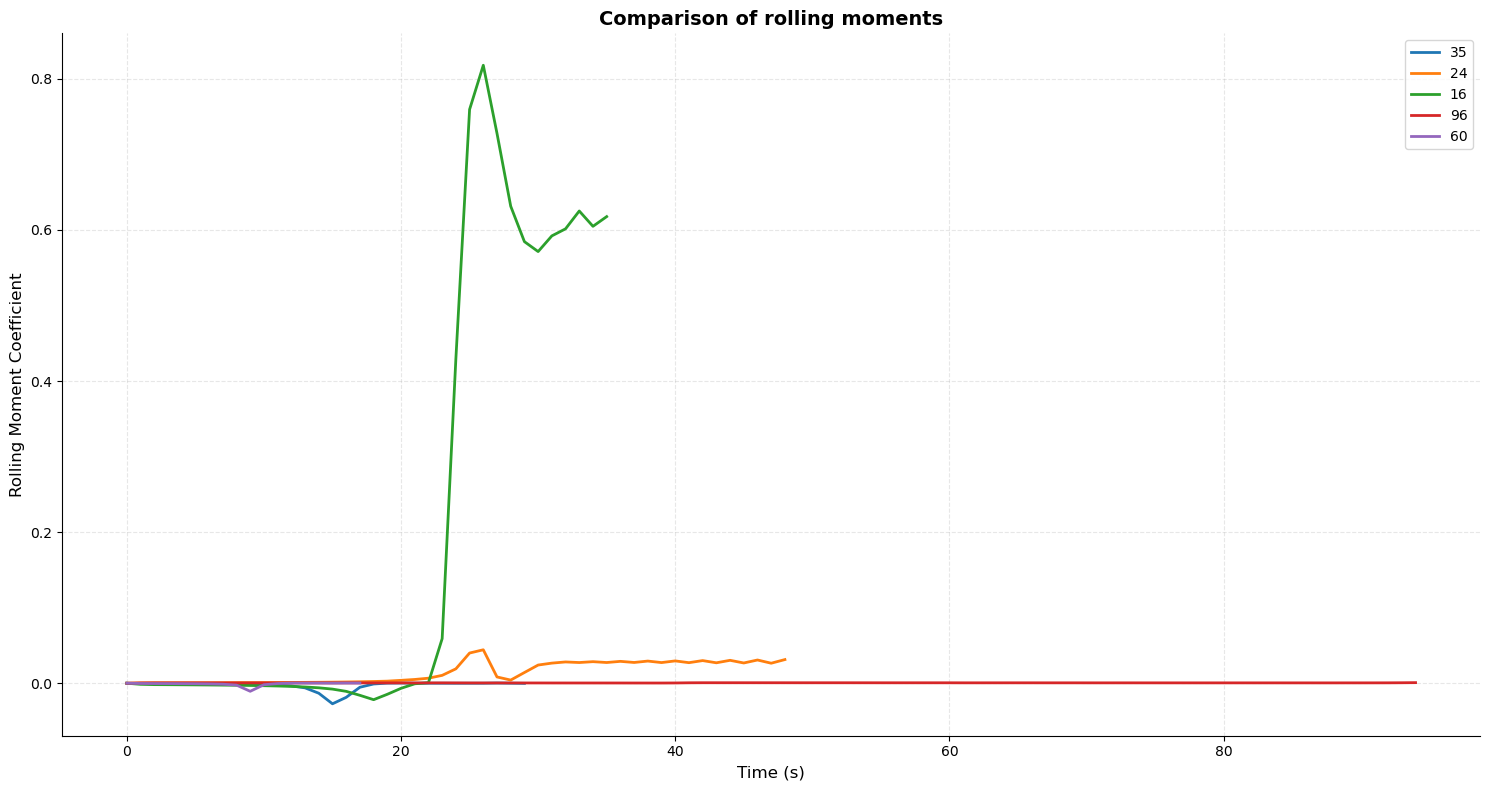

In [11]:
plt.figure(figsize=(15, 8))
plt.grid(alpha=0.3, linestyle='--')

for i, (df, label) in enumerate(zip(dataframes, labels)):
    plt.plot(df["C_l"], label=label, linewidth=2)

plt.legend(title="Scenarios", fontsize='medium', frameon=False)
plt.legend()

# Add labels and title for better clarity
plt.xlabel("Time (s)", fontsize=12)
plt.ylabel("Rolling Moment Coefficient", fontsize=12)
plt.title("Comparison of rolling moments", fontsize=14, fontweight='bold')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

plt.gca().spines['top'].set_visible(False) 
plt.gca().spines['right'].set_visible(False) 

# Show the plot
plt.show()

### WARNING: The time doesn't correspond to the true time of the simulations as encounter trajectories were cropped and don't necessarily start at 0


In [14]:
# Simulation 92 is a great example of no RMC for a perfect 90 deg angle
aggregated_params.query("simulation_index == 96")

,wake_id,aircraft_type,crop_distance,speed,t_target,theta,phi,x_target,y_target,z_target,simulation_index
956,0,A320,1500.0,91,122,-12,-4,-1.0,-356.859769,1945.911774,96


In [16]:
test = pd.read_parquet("/backup/kruu/wake_encounter_simulations/encounters/96/encounter_df.parquet")
test

,X,Y,Z,hit_gate,dist_left_wake,dist_right_wake
Time,,,,,,
28.0,-8368.074577,1417.284555,1821.851518,False,1524.071981,1486.970971
29.0,-8279.063145,1398.410679,1823.171307,False,1507.941156,1470.833069
30.0,-8190.051713,1379.536803,1824.491097,False,1491.810655,1454.695455
31.0,-8101.040282,1360.662928,1825.810887,False,1475.681429,1438.560075
32.0,-8012.028850,1341.789052,1827.130677,False,1459.554695,1422.425160
...,...,...,...,...,...,...
119.0,-268.034295,-300.238141,1941.952404,False,100.347890,80.530254
120.0,-179.022863,-319.112017,1943.272194,False,91.733376,77.653383
121.0,-90.011432,-337.985893,1944.591984,False,85.266396,78.007277


In [31]:
# Around 3% of the simulation don't converge
(1000 - len(results))/10

3.5

In [25]:
# Calulation of quantiles on the maximum RMC of each simulation

# all_c_l_values = pd.concat([df['C_l'].abs() for df in results.values()])
max_c_l_values = pd.Series([df['C_l'].abs().max() for df in results.values()])
quantiles = max_c_l_values.quantile([0.25, 0.5, 0.75, 0.90, 0.95, 0.99])
print(quantiles)

keys_above_quantile = [
    key for key, df in results.items()
    if (df['C_l'].abs() >= max_c_l_values.quantile(0.90)).any()
]

severe_encounter = aggregated_params.query(f"simulation_index in {keys_above_quantile}")

0.25    0.004261
0.50    0.015028
0.75    0.043942
0.90    0.105820
0.95    0.210961
0.99    2.333823
dtype: float64


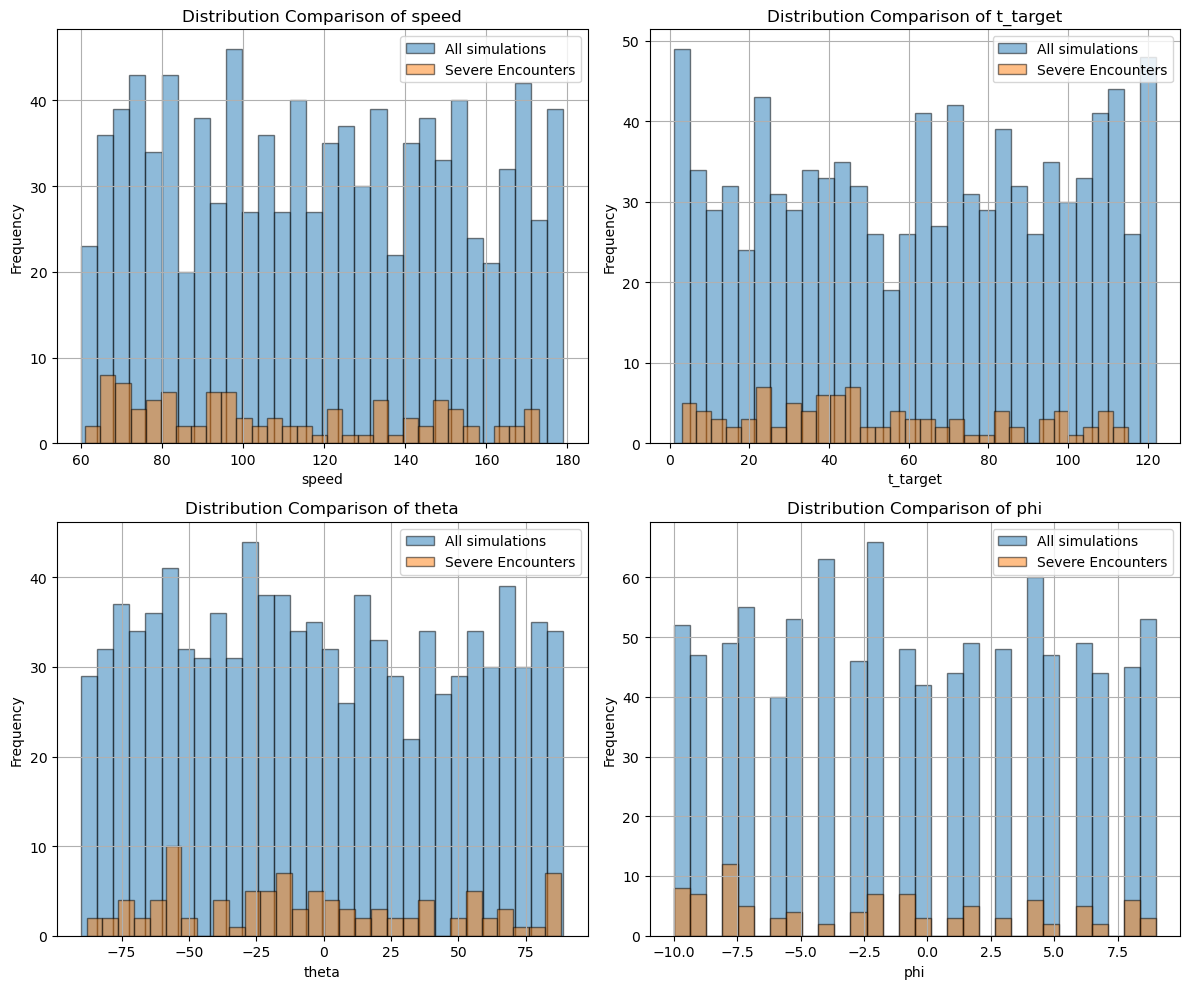

In [26]:
columns_to_plot = ['speed', 't_target', 'theta', 'phi']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten to easily iterate through axes

for i, column in enumerate(columns_to_plot):
    if column in aggregated_params.columns and column in severe_encounter.columns:
        axes[i].hist(aggregated_params[column], bins=30, alpha=0.5, label='All simulations', edgecolor='black')
        axes[i].hist(severe_encounter[column], bins=30, alpha=0.5, label='Severe Encounters', edgecolor='black')
        axes[i].set_title(f'Distribution Comparison of {column}')
        axes[i].set_xlabel(column)
        axes[i].set_ylabel('Frequency')
        axes[i].legend(loc='upper right')
        axes[i].grid(True)
    else:
        print(f"Column {column} not found in dataframe.")

plt.tight_layout()
plt.show()

# Linear Regression

Predict the max RMC depending on:
- speed
- t_target
- theta
- phi
- minimum distance to wake (not necessarily at t_target)

In [32]:
target = {i:df['C_l'].abs().max() for i, df in results.items()}
data = aggregated_params[["speed", "t_target", "theta", "phi", "simulation_index"]]

min_dist_wake = {}
for i in data.simulation_index.unique():
    temp = pd.read_parquet("/backup/kruu/wake_encounter_simulations/encounters/"+str(i)+"/encounter_df.parquet")
    min_dist_wake[i] = min(temp.dist_left_wake.min(), temp.dist_right_wake.min())
    
data['min_dist_wake'] = data['simulation_index'].map(min_dist_wake)
data['target'] = data['simulation_index'].map(target)
data

/tmp/ipykernel_2170311/2768808620.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['min_dist_wake'] = data['simulation_index'].map(min_dist_wake)
/tmp/ipykernel_2170311/2768808620.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['simulation_index'].map(target)


,speed,t_target,theta,phi,simulation_index,min_dist_wake,target
0,142,34,14,-1,0,77.277097,0.045441
1,60,63,-70,-9,1,34.234363,0.100742
2,119,17,-19,-4,10,51.725879,0.096714
3,97,40,-6,-9,100,4.325871,0.491842
4,141,4,-10,7,101,124.911608,0.072425
...,...,...,...,...,...,...,...
995,146,12,79,1,995,50.801544,0.086652
996,173,10,70,-8,996,73.140948,0.023543
997,117,37,25,4,997,46.870728,0.023320
998,92,110,-38,-6,998,136.713247,0.000247


In [33]:
#droping missing values if needed
data = data.dropna()

In [35]:
model_lm = smf.ols(
    "target ~ speed + t_target + theta + phi + min_dist_wake", 
    data, 
)

res_lm = model_lm.fit()
res_lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2020
Date:                Fri, 03 Jan 2025   Prob (F-statistic):              0.962
Time:                        08:43:53   Log-Likelihood:                -3977.8
No. Observations:                 965   AIC:                             7968.
Df Residuals:                     959   BIC:                             7997.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4926      1.972      0.757      0.449      -2.378       5.363
speed            -0.0025      0.014     -0.177      0.860      -0.030       0.025
t_target         -0.0052      0.015     -0.360      0.719      -0.034       0.023
theta            -0.0085      0.009     -0.922      0.357      -0.027       0.010
phi              -0.0010      0.085     -0.011      0.991      -0.167       0.165
min_dist_wake -9.322e-05      0.010     -0.009      0.993      -0.020       0.020
==============================================================================
Omnibus:                     2287.167   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10822691.611
Skew:                          22.197   Prob(JB):                         0.00
Kurtosis:                     519.909   Cond. No.                         647.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""